In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import re
import librosa
from imblearn.combine import *
from sklearn import preprocessing
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from sklearn import linear_model
import scipy
from util import convertEMF
import pywt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
palette = 'deep'
sns.set(font='SimHei', font_scale=1.2, palette=palette)  # 解决Seaborn中文显示问题

In [31]:
df = pd.read_csv('../数据/population.csv')
df

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,Population aged 15 to 19 years,Population aged 20 to 29 years,Population aged 30 to 39 years,Population aged 40 to 49 years,Population aged 50 to 59 years,Population aged 60 to 69 years,Population aged 70 to 79 years,Population aged 80 to 89 years,Population aged 90 to 99 years,Population older than 100 years
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,757113,1241348,909953,661807,467170,271905,92691,9499,123,0.0
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,768616,1260904,922765,667015,468881,273286,94358,10155,118,0.0
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,781411,1280288,935638,672491,470898,274852,96026,10721,139,0.0
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,794308,1298803,948321,678064,472969,276577,97705,11254,166,0.0
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,806216,1316768,961484,684153,475117,278210,99298,11793,190,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18067,Zimbabwe,2017,14751101,464521.0,2287404,6217928,9224369,8056253,8532951,7476399,...,1690993,2422873,2021973,1088878,570769,467775,200927,59789,8974,222.0
18068,Zimbabwe,2018,15052191,466524.0,2283576,6291632,9385132,8264833,8760331,7689502,...,1732035,2474502,2058928,1155537,585529,476214,208587,59700,9299,228.0
18069,Zimbabwe,2019,15354606,468844.0,2281740,6367398,9543409,8473475,8986973,7909270,...,1759205,2546398,2085636,1220993,606266,479827,218763,60339,9546,235.0
18070,Zimbabwe,2020,15669663,470340.0,2287105,6449021,9709135,8691594,9220402,8139472,...,1776240,2640150,2101852,1291333,631541,476507,231604,61546,9629,240.0


# 全球总人口随时间变化的趋势折线图

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(df, x='Year', y='Population')
N = 10  # 每隔2年显示一个刻度
plt.xticks(df['Year'][::N], rotation=90)
plt.ylabel('人口数量')
plt.xlabel('年份')
plt.tight_layout()
convertEMF.exportEmf('全球总人口随时间变化的趋势折线图')
plt.show()

In [ ]:
df['Growth Rate'] = df['Population'].pct_change()
df

# 全球人口增长率

In [ ]:
增长率df = df[df['Year'] >= 2011]
plt.figure(figsize=(8, 6))
sns.lineplot(增长率df, x='Year', y='Growth Rate')
N = 1
plt.xticks(增长率df['Year'][::N], rotation=90)
plt.ylabel('人口增长率')
plt.xlabel('年份')
plt.tight_layout()
plt.show()

分别统计所有国家 2011~2021 的人口增长率和增长人数。
给出人口增长率最大的前 10 个国家和最小的后 10 个国家名单，人口增长数最多
的前 10 个国家和最少的后 10 个国家名单。

In [ ]:
pivotDf = pd.pivot(df.iloc[:, :-3], index='Country name', columns='Year', values='Population')
pivotDf = pivotDf.reset_index()
pivotDf

In [ ]:
# 计算人口增长率
pivotDf['Growth Rate'] = pivotDf.loc[:, [2011, 2021]].pct_change(axis=1).iloc[:, -1]

# 计算增长人数
pivotDf['Population Growth'] = pivotDf[2021] - pivotDf[2011]

In [ ]:
# 按照增长率排序
df_sorted = pivotDf.sort_values(by='Growth Rate', ascending=False)
fig, axs = plt.subplots(2, 1, figsize=(13, 13))
sns.lineplot(df_sorted.head(50), x='Country name', y='Growth Rate', ax=axs[0])
sns.lineplot(df_sorted.tail(50), x='Country name', y='Growth Rate', ax=axs[1])
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
plt.tight_layout()
convertEMF.exportEmf('增长率前50个和后50个')
plt.show()

# 提取增长率最大的前10个国家和增长率最小的后10个国家
top_10_countries = df_sorted.head(10)['Country name'].tolist()
bottom_10_countries = df_sorted.tail(10)['Country name'].tolist()

print("人口增长率最大的前10个国家:")
print(top_10_countries)

print("\n人口增长率最小的后10个国家:")
print(bottom_10_countries)

D:\Users\win\AppData\Local\Temp\ipykernel_38152\2565583135.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(truncated_labels)
D:\Users\win\AppData\Local\Temp\ipykernel_38152\2565583135.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(truncated_labels)


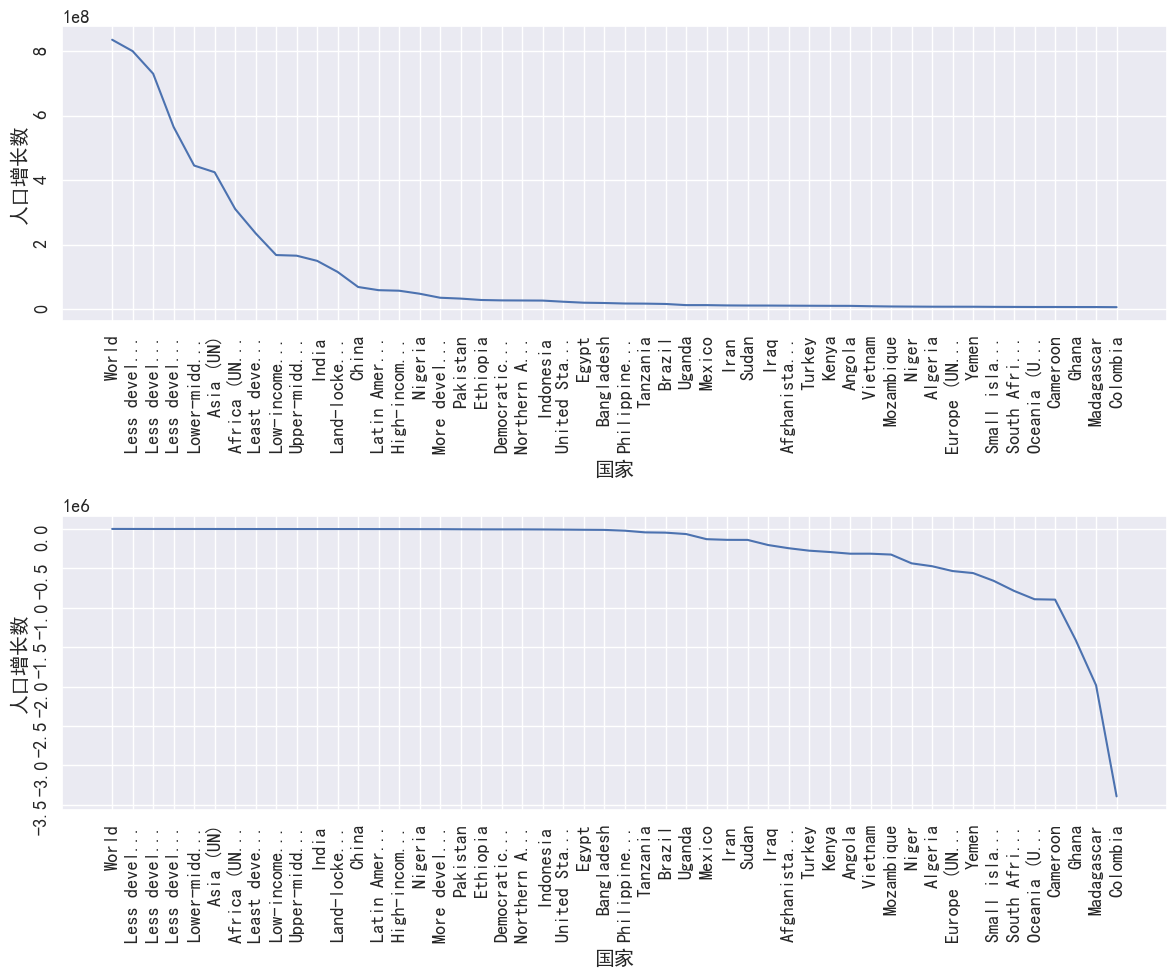

人口增长数量最大的前10个国家:
['World', 'Less developed regions', 'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 'Lower-middle-income countries', 'Asia (UN)', 'Africa (UN)', 'Least developed countries', 'Low-income countries', 'Upper-middle-income countries']

人口增长数量最小的后10个国家:
['Bosnia and Herzegovina', 'Moldova', 'Greece', 'Bulgaria', 'Italy', 'Romania', 'Venezuela', 'Syria', 'Ukraine', 'Japan']


In [22]:
df_sorted = pivotDf.sort_values(by='Population Growth', ascending=False).reset_index(names=['Year']).rename_axis(None, axis=1)
df_sorted

In [ ]:

df_sorted = pivotDf.sort_values(by='Population Growth', ascending=False).reset_index(names=['Year']).rename_axis(None, axis=1)
fig, axs = plt.subplots(2, 1, figsize=(13, 13))
sns.lineplot(df_sorted.head(50), x='Country name', y='Population Growth', ax=axs[0])
axs[0].tick_params(rotation=90)

# 设置刻度标签的长度和格式
tick_labels = [str(year) for year in df_sorted.head(50)['Year'][::N]]  # 将刻度标签转换为字符串
max_label_len = 4  # 最大刻度标签长度
truncated_labels = [label[:max_label_len] + '...' if len(label) > max_label_len else label for label in tick_labels]  # 截断超出部分并添加省略号
axs[0].set_xticklabels(truncated_labels)

sns.lineplot(df_sorted.tail(50), x='Country name', y='Population Growth', ax=axs[1])
axs[1].tick_params(rotation=90)
plt.tight_layout()
convertEMF.exportEmf('增长人数前50个和后50个')
plt.show()

# 提取增长率最大的前10个国家和增长率最小的后10个国家
top_10_countries = df_sorted.head(10)['Country name'].tolist()
bottom_10_countries = df_sorted.tail(10)['Country name'].tolist()

print("人口增长数量最大的前10个国家:")
print(top_10_countries)

print("\n人口增长数量最小的后10个国家:")
print(bottom_10_countries)